Requires `experiment_wrapper` package: Either `pip install` or clone the repo: https://github.com/stonkens/experiment_wrapper and `pip install -e .`
```
pip install --upgrade jupyter matplotlib experiment-wrapper 
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) \n[GCC 12.3.0]'

In [3]:
import cbf_opt
import jax.numpy as jnp

In [4]:
from experiment_wrapper import TimeSeriesExperiment, StateSpaceExperiment

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
class ACC_Dynamics(cbf_opt.ControlAffineDynamics):
    STATES = ['P', 'V', 'dP']
    CONTROLS = ['ACC']
    def __init__(self, params, **kwargs):
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2
        self.v0 = params["v0"]
        super().__init__(params, **kwargs)
        
    def open_loop_dynamics(self, state, time=0.):
        return jnp.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_matrix(self, state, time=0.):
        return jnp.array([[0], [1 / self.mass], [0]])

In [7]:
import jax
class ACC_CBF(cbf_opt.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        self.Th = params["Th"]
        self.cd = params["cd"]
        self._grad_vf = jax.vmap(jax.grad(self.vf, argnums=0), in_axes=(0, None))
        super().__init__(dynamics, **kwargs)

    def vf(self, state, time=None):
        return state[...,2] - self.Th * state[..., 1] - (state[..., 1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=None):
        return 0.0
    
    # def _grad_vf(self, state, time=None):
    #     return jnp.array([0, -self.Th - ()])
    #     dvf_dx = jnp.zeros_like(state)
    #     dvf_dx[1] = - self.Th  - (state[1] - self.dynamics.v0) / (self.cd * self.dynamics.g)
    #     dvf_dx[2] = 1.0
    #     return dvf_dx

In [8]:
params = dict()
params["n_dims"] = 3
params["control_dims"] = 1
params["dt"] = 0.01
params["g"] = 9.81
params['v0'] = 14  # lead vehicle velocity
params['f0'] = 0.1  # friction coefficient
params['f1'] = 5  # friction coefficient
params['f2'] = 0.25  # friction coefficient
params['mass'] = 1650  # vehicle mass

acc = ACC_Dynamics(params)
acc.dt = 0.01
batched_acc = cbf_opt.BatchedDynamics(acc)

/home/sasslab/dev/dependencies/cbf_opt/cbf_opt/dynamics.py:21: RuntimeWarning: dt not set, set manually when running self.step
  warnings.warn("dt not set, set manually when running self.step", RuntimeWarning)


In [9]:
cbf_params = dict()
cbf_params["cd"] = 0.3
cbf_params["Th"] = 1.8
acc_cbf = ACC_CBF(batched_acc, cbf_params)

In [10]:
vd = 24
umax = jnp.array([cbf_params['cd'] * params['mass'] * params['g']])
umin = -umax
alpha = lambda x: 5 * x
nominal_policy = lambda x, t: jnp.atleast_2d(jnp.clip(-1000 * (x[..., 1:2] - vd), umin, umax))
acc_asif = cbf_opt.ControlAffineASIF(batched_acc, acc_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [11]:
nominal_policy(jnp.zeros(3), 0).shape

(1, 1)

In [12]:
x0 = jnp.array([0, 30, 100])
x0_2 = jnp.array([0, 25, 70])
rollout_opt = TimeSeriesExperiment('rollout_opt', start_x=jnp.array([x0, x0_2]), n_sims_per_start=1, t_sim=10)

In [13]:
import logging
logging.getLogger().setLevel(logging.ERROR)
acc.dt = 0.01
results_df = rollout_opt.run(batched_acc, {'Nominal': nominal_policy, 'CBF': acc_asif})

Controller rollout: 100%|██████████| 1000/1000 [00:18<00:00, 54.03it/s]


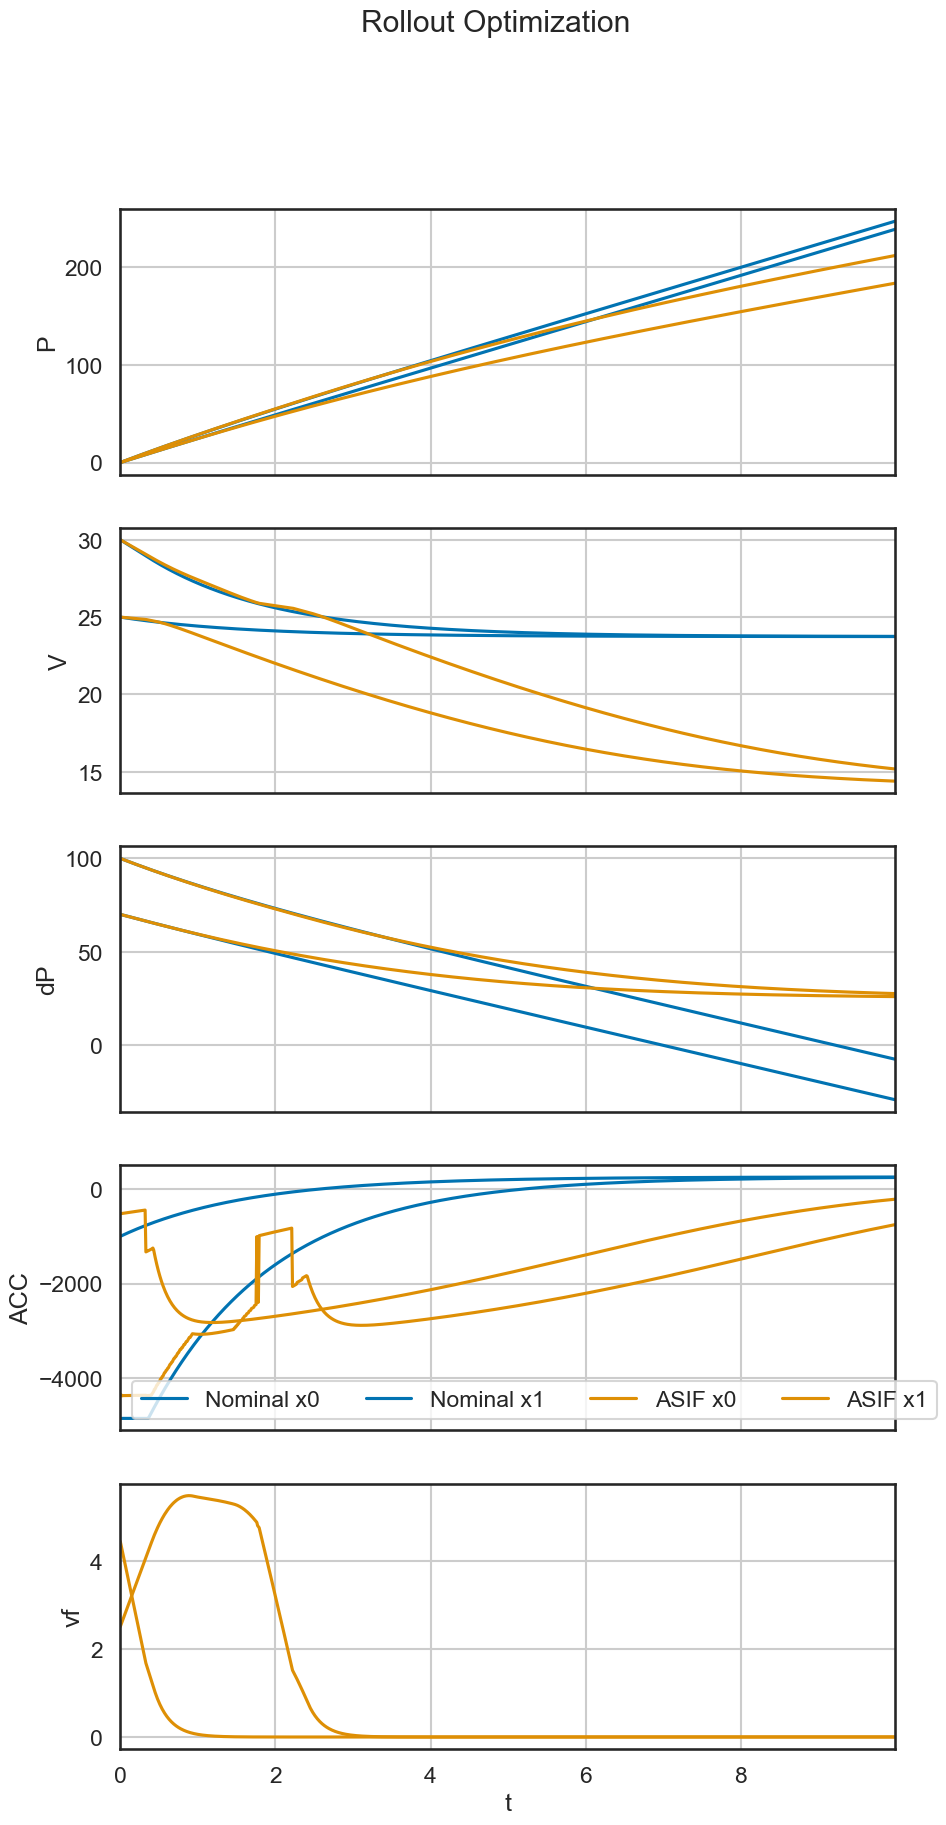

In [14]:
fig_handle = rollout_opt.plot(acc, results_df, extra_measurements=['vf'])
fig = fig_handle[0][1]
fig.suptitle('Rollout Optimization')
# fig.tight_layout()
for ax in fig.axes:
    ax.grid(True)
fig.axes[-2].legend(['Nominal x0', 'Nominal x1', 'ASIF x0', 'ASIF x1'], ncol=4);

In [15]:
ss_exp = StateSpaceExperiment('ss_opt', x_indices=[1, 2], start_x =jnp.array([x0, x0_2]), n_sims_per_start=1, t_sim=10)

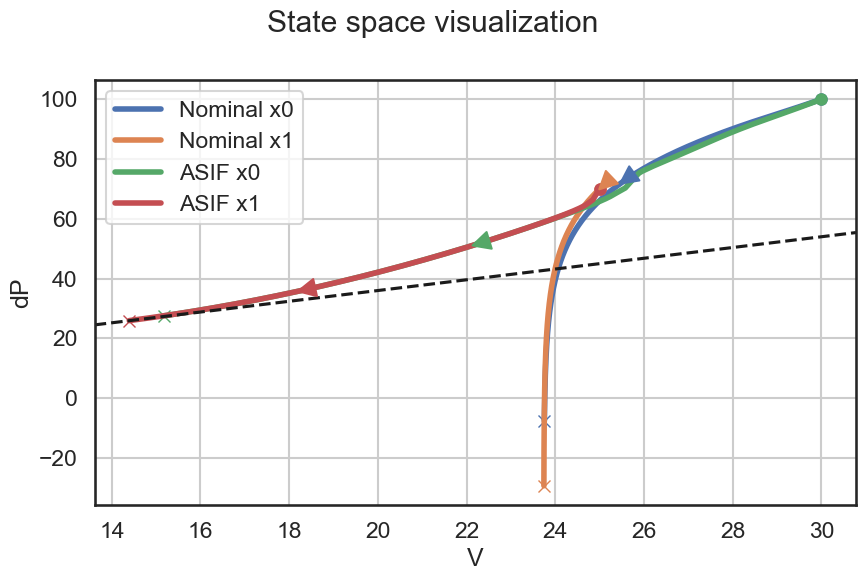

In [16]:
fig_handle = ss_exp.plot(acc, results_df)
fig_ss = fig_handle[0][1]
fig_ss.suptitle('State space visualization')
fig_ss.tight_layout()
fig_ss.axes[0].grid(True)
xmin, xmax = fig_ss.axes[0].get_xlim()
fig_ss.axes[0].set_xlim(xmin, xmax)
xrange = jnp.linspace(xmin, xmax, 100)
fig_ss.axes[0].legend(fig_ss.axes[0].get_lines()[::3], ['Nominal x0', 'Nominal x1', 'ASIF x0', 'ASIF x1'])
fig_ss.axes[0].plot(xrange, acc_cbf.Th * xrange, '--k');